# Introduction

Notebook to aggregate the running of models in the context of traceability between **features** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

from modules.models_runner import feat_br_strat_runner

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
vol_strat_runner = feat_br_strat_runner.Feat_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

Feat_BR Volunteers Matrix shape: (91, 19)
Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


In [4]:
from modules.utils import aux_functions

aux_functions.highlight_df( evals_df_4[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

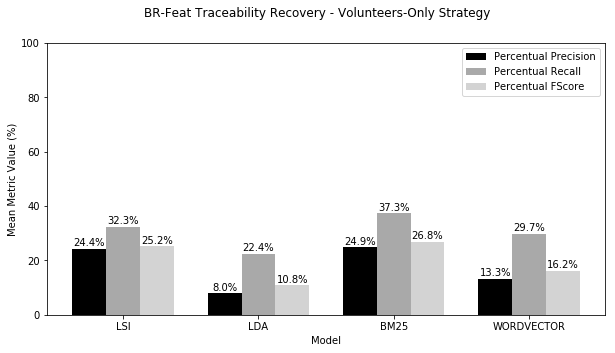

In [5]:
evaluator_4.plot_evaluations_3(evals_df_4, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

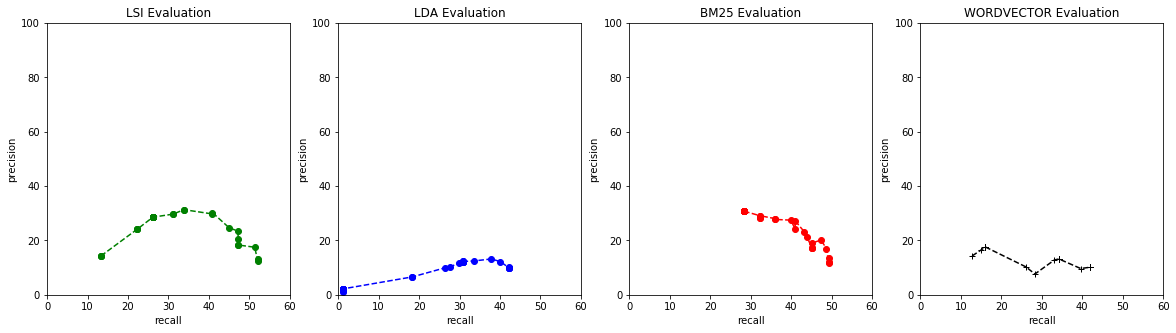

In [6]:
evaluator_4.plot_evaluations_4(evals_df_4)

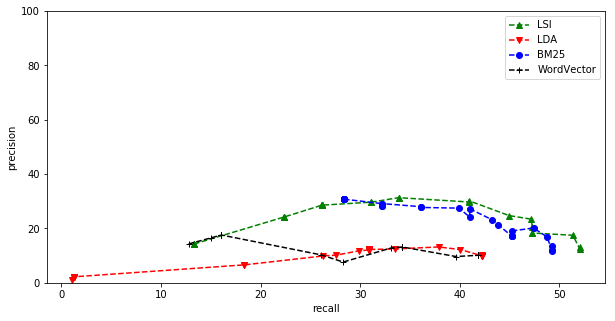

In [7]:
evaluator_4.plot_evaluations_5(evals_df_4)

In [33]:
evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(top,cos)) & (evals_df_4.model == m)]

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
119,wordvector,top_5_cosine_0.9,7.64,28.3,11.44,precision recall fscore Bug_Nu...,0.9,5.0,Bug_Number 1248267 1248268 125...


### Retrieved Traces

In [26]:
models = ['lsi','lda','bm25','wordvector']
tops = [1,3,5]
cosines = [0.0, 0.9]

for m in models:
    for top in tops:
        for cos in cosines:
            trace_links = evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(top,cos)) & (evals_df_4.model == m)].iloc[0,:].trace_links_df
            s = 0
            for col in trace_links.columns:
                s = s + trace_links[col].sum()
            print('Retrieved (m={}, t={}, c={}): {}'.format(m,top,cos,s))

Retrieved (m=lsi, t=1, c=0.0): 91
Retrieved (m=lsi, t=1, c=0.9): 24
Retrieved (m=lsi, t=3, c=0.0): 273
Retrieved (m=lsi, t=3, c=0.9): 24
Retrieved (m=lsi, t=5, c=0.0): 455
Retrieved (m=lsi, t=5, c=0.9): 24
Retrieved (m=lda, t=1, c=0.0): 91
Retrieved (m=lda, t=1, c=0.9): 32
Retrieved (m=lda, t=3, c=0.0): 273
Retrieved (m=lda, t=3, c=0.9): 90
Retrieved (m=lda, t=5, c=0.0): 455
Retrieved (m=lda, t=5, c=0.9): 90
Retrieved (m=bm25, t=1, c=0.0): 91
Retrieved (m=bm25, t=1, c=0.9): 91
Retrieved (m=bm25, t=3, c=0.0): 273
Retrieved (m=bm25, t=3, c=0.9): 118
Retrieved (m=bm25, t=5, c=0.0): 455
Retrieved (m=bm25, t=5, c=0.9): 119
Retrieved (m=wordvector, t=1, c=0.0): 91
Retrieved (m=wordvector, t=1, c=0.9): 72
Retrieved (m=wordvector, t=3, c=0.0): 273
Retrieved (m=wordvector, t=3, c=0.9): 205
Retrieved (m=wordvector, t=5, c=0.0): 455
Retrieved (m=wordvector, t=5, c=0.9): 315


### Relevant Traces

In [31]:
from modules.utils import aux_functions

models = ['lsi','lda','bm25','wordvector']
tops = [1,3,5]
cosines = [0.0, 0.9]

for m in models:
    for top in tops:
        for cos in cosines:
            trace_links = evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(top,cos)) & (evals_df_4.model == m)].iloc[0,:].trace_links_df
            tp_amount = len(aux_functions.get_true_positives(oracle_df=vol_strat_runner.get_oracle(), output_df = trace_links))
            print('Relevant (m={}, t={}, c={}): {}'.format(m,top,cos,tp_amount))

Relevant (m=lsi, t=1, c=0.0): 26
Relevant (m=lsi, t=1, c=0.9): 13
Relevant (m=lsi, t=3, c=0.0): 50
Relevant (m=lsi, t=3, c=0.9): 13
Relevant (m=lsi, t=5, c=0.0): 57
Relevant (m=lsi, t=5, c=0.9): 13
Relevant (m=lda, t=1, c=0.0): 2
Relevant (m=lda, t=1, c=0.9): 1
Relevant (m=lda, t=3, c=0.0): 33
Relevant (m=lda, t=3, c=0.9): 18
Relevant (m=lda, t=5, c=0.0): 45
Relevant (m=lda, t=5, c=0.9): 18
Relevant (m=bm25, t=1, c=0.0): 28
Relevant (m=bm25, t=1, c=0.9): 28
Relevant (m=bm25, t=3, c=0.0): 47
Relevant (m=bm25, t=3, c=0.9): 32
Relevant (m=bm25, t=5, c=0.0): 54
Relevant (m=bm25, t=5, c=0.9): 32
Relevant (m=wordvector, t=1, c=0.0): 16
Relevant (m=wordvector, t=1, c=0.9): 13
Relevant (m=wordvector, t=3, c=0.0): 36
Relevant (m=wordvector, t=3, c=0.9): 27
Relevant (m=wordvector, t=5, c=0.0): 46
Relevant (m=wordvector, t=5, c=0.9): 29


### Delete Variables

## Union Strategy

In [ ]:
exp_vol_union_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Union_Strat_Runner()
exp_vol_union_strat_runner.execute()

evaluator_1 = exp_vol_union_strat_runner.get_evaluator() 
evals_df_1 = exp_vol_union_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_1.head()

In [ ]:
evaluator_1.plot_evaluations_4(evals_df_1)

In [ ]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Plots

In [ ]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

### Delete Variables

## Intersec Strategy

In [ ]:
exp_vol_intersec_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Intersec_Strat_Runner()
exp_vol_intersec_strat_runner.execute()

evaluator_2 = exp_vol_intersec_strat_runner.get_evaluator() 
evals_df_2 = exp_vol_intersec_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_2.head()

### Plots

In [ ]:
evaluator_2.plot_evaluations_3(evals_df_2, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

In [ ]:
evaluator_2.plot_evaluations_4(evals_df_2)

In [ ]:
evaluator_2.plot_evaluations_5(evals_df_2)

### Delete Variables

## Expert Only Strategy

In [ ]:
exp_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Strat_Runner()
exp_strat_runner.execute()

evaluator_3 = exp_strat_runner.get_evaluator() 
evals_df_3 = exp_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_3.head()

### Plots

In [ ]:
evaluator_3.plot_evaluations_3(evals_df_3, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

In [ ]:
evaluator_3.plot_evaluations_4(evals_df_3)

In [ ]:
evaluator_3.plot_evaluations_5(evals_df_3)

### Delete Variables